In [1]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random
from itertools import chain
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_communities = 800
community_size = 3
orphans = 800
total_ppl = n_communities * community_size + orphans

n_strong_conns = int(total_ppl * 1.5)
n_weak_conns = n_strong_conns

core_strength = 0.6
strong_strength = 0.4
p_strong_interact = 5 / 7
weak_strength = 0.1

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw={'strength': core_strength}, 
        strong_kw={'strength': strong_strength}, 
        weak_kw={'strength': weak_strength}
    )
    return graph

with fix_random():
    graph0 = generate_graph()

In [3]:
def vaccination_random(runner):
    nodes = [n for n in graph0.nodes]
    with fix_random():
        random.shuffle(nodes)
    return (n for n in nodes if n not in runner.deaths)

In [4]:
def vaccination_skipping_survivors(runner):
    nodes = [n for n in graph0.nodes]
    with fix_random():
        random.shuffle(nodes)
    g1 = (n for n in nodes if n not in runner.deaths and n not in runner.survived)
    g2 = (n for n in nodes if n not in runner.deaths and n not in runner.vaccinated)
    return chain(g1, g2)

In [5]:
def ct_strong_edges(node):
    strong_edges = [edge for edge in graph0.outbound_edges(node) if edge.attr('kind') == 'strong']
    return len(strong_edges)

node_edge_ct = {node: ct_strong_edges(node) for node in graph0.nodes}

def vaccination_order_by_edges(runner):
    first_priority = []
    second_priority = []
    third_priority = []
    
    edge_ct_values = list(node_edge_ct.values())
    u = np.mean(edge_ct_values)
    sd = np.std(edge_ct_values)
    for node, strong_edge_ct in node_edge_ct.items():
        if strong_edge_ct > u + 2 * sd:
            first_priority.append(node)
        elif u + 2 * sd >= strong_edge_ct > u + sd:
            second_priority.append(node)
        else:
            third_priority.append(node)
    
    with fix_random():
        random.shuffle(first_priority)
        random.shuffle(second_priority)
        random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in runner.deaths:
            yield node

In [6]:
def generate_age():
    x = random.uniform(0, 1)
    if x < 0.1:
        return random.uniform(60, 70)
    elif 0.1 <= x < 0.15:
        return random.uniform(70, 80)
    elif 0.15 <= x < 0.186:
        return random.uniform(80, 90)
    else:
        return random.uniform(0, 60)

def assign_p_death(graph, max_age=90, max_p_death=0.7, decay_factor=8):
    result = {}
    for node in graph.nodes:
        age = generate_age()
        diff = max_age - age
        p_death = max_p_death * np.exp(-diff / (max_age / decay_factor))
        result[node] = p_death
    return result

p_deaths = assign_p_death(graph0)

def vaccination_order_by_p_death(runner):
    first_priority = []
    second_priority = []
    third_priority = []
    for node, p_death in p_deaths.items():
        if p_death > 0.15:
            first_priority.append(node)
        elif 0.05 < p_death <= 0.15:
            second_priority.append(node)
        else:
            third_priority.append(node)
            
    with fix_random():
        random.shuffle(first_priority)
        random.shuffle(second_priority)
        random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in runner.deaths:
            yield node

In [107]:
def reset_non_core_edges(transmission):
    graph = transmission.graph
    weak_edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in weak_edges_to_remove:
        graph.remove_edge(prev_weak_edge)
        
    strong_edges = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'strong']

    n_new_weak_edges = len(weak_edges_to_remove)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=weak_strength)
        
    for edge in strong_edges:
        new_strength = strong_strength if test(p_strong_interact) else 0
        graph.update_edge(edge, strength=new_strength)
        
        
class VaccineRunner:
    def __init__(self, rollout=None, start_day=None, start_cases=None):
        self.start_day = start_day
        self.start_cases = start_cases
        self.daily_vaccinations = daily_vaccinations
        
        self.deaths = set()
        self.survived = set()
        self.vaccinated = set()
        self.rollout = None if rollout is None else rollout(self)
        
    def should_vaccinate(self, transmission):
        if self.rollout is None:
            return False
        if self.start_day is not None:
            return transmission.steps >= self.start_day
        if self.start_cases is not None:
            hist = transmission.history
            return len(hist) and hist[-1].broadcasts >= self.start_cases
        return False
        
    def __call__(self, transmission):
        while True:
            if self.should_vaccinate(transmission):
                try:
                    for _ in range(self.daily_vaccinations):
                        self.vaccinated.add(next(self.rollout))
                except StopIteration:
                    pass

            # tally deaths
            tracker = transmission.broadcast_tracker
            for node in tracker:
                if tracker.get(node, 9999) <= 0:
                    if node not in self.survived and test(p_deaths.get(node, 0)):
                        self.deaths.add(node)
                    else:
                        self.survived.add(node)

            # reset weak edges
            reset_non_core_edges(transmission)
            try:
                next(transmission)
                yield
            except StopIteration:
                return

In [108]:
run_to = 100
incubation_period = rv.randint(1, 10)
contagious_for = rv.choice(0, 1, 2)
daily_vaccinations = 50

In [9]:
def test_transmit(transmission, edge, vaccinated, vaccine_factor=0.05):
    edge_strength = edge.attr('strength')
    if edge.to_node in vaccinated:
        return test(edge_strength * vaccine_factor)
    return test(edge_strength)

def generate_sim(graph, runner, patient0):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=patient0,
            incubation_period=incubation_period,
            contagious_for=contagious_for,
            runner=runner,
            test_transmit=partial(test_transmit, vaccinated=runner.vaccinated)
        )

## Run the simulations

WARNING: these take a while.

In [109]:
def run_ensemble(n, rollout, **start_kw):
    runners = []
    results = []
    for i in range(n):
        runner = VaccineRunner(rollout, **start_kw)
        sim = generate_sim(graph0, runner, patient0=i)
        result = run_simulations(sim, to=run_to)
        
        runners.append(runner)
        results.append(result)
    
    return runners, results

In [11]:
controls = run_ensemble(6)

NameError: name 'vaccinate_essential_first_runner' is not defined

In [110]:
vaccine_random = run_ensemble(6, vaccination_random, start_cases=150)

In [121]:
vaccine_skip_survivors = run_ensemble(6, vaccination_skipping_survivors, start_cases=150)

In [122]:
vaccine_elderly_first = run_ensemble(6, vaccination_order_by_p_death, start_cases=150)

In [123]:
vaccine_essential_workers_first = run_ensemble(6, vaccination_order_by_edges, start_cases=150)

In [130]:
for name, scenario in zip(
    ('control', 'vaccinate randomly', 'vaccinate those who havent gotten it first', 'vaccinate elderly', 'vaccinate essential workers'),
    (controls, vaccine_random, vaccine_skip_survivors, vaccine_elderly_first, vaccine_essential_workers_first)
):
    deaths = [len(runner.deaths) for runner, _ in zip(*scenario)]
    print(f'{name}: {np.mean(deaths)} +/- {np.std(deaths)}')

control: 127.5 +/- 8.597480251019288
vaccinate randomly: 113.33333333333333 +/- 6.128258770283412
vaccinate those who havent gotten it first: 103.0 +/- 9.539392014169456
vaccinate elderly: 63.166666666666664 +/- 8.858454843945541
vaccinate essential workers: 112.16666666666667 +/- 6.542595475463507


In [36]:
runners_ctrl, results_ctrl = controls
runners_vaccinate_random, r

In [115]:
runners2, results2 = vaccine_random

# Results

In [137]:
def cases(sim, day):
    index = -1 if day >= len(sim.history) else day
    return sim.history[index].broadcasts

def mean_sd_values(results, days):
    means = []
    sds = []
    for day in days:
        cases_through_results = [cases(sim, day) for sim in results]
        u = np.mean(cases_through_results)
        sd = np.std(cases_through_results)
        means.append(u)
        sds.append(sd)
    return means, sds

def plot_means(scenarios, days, labels=None, color=None):
    fig = plt.figure(figsize=(12, 12))
    plt.title('Virus transmission vs. T (days) [Control; six runs]', fontsize=16)
    lines = []
    for result in scenarios:
        means, sds = mean_sd_values(result, days)
        result = plt.errorbar(days, means, yerr=sds, errorevery=2, elinewidth=0.5)
        
        lines.append(result.lines[0])

    if labels:
        plt.legend(lines, labels, loc='upper left')
    plt.xlabel('Days elapsed')
    plt.ylabel('Cases')

In [124]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

def plot_ensemble(results, labels=None, color=None):
    fig = plt.figure(figsize=(12, 12))
    plt.title('Virus transmission vs. T (days)', fontsize=16)
    lines = []
    for sim in results:
        line, = plt.plot(range(run_to), list(sim_sequence(sim, run_to)), 'o-', color=color)
        lines.append(line)

    if labels:
        plt.legend(lines, labels, loc='upper left')
    plt.xlabel('Days elapsed')
    plt.ylabel('Cases')

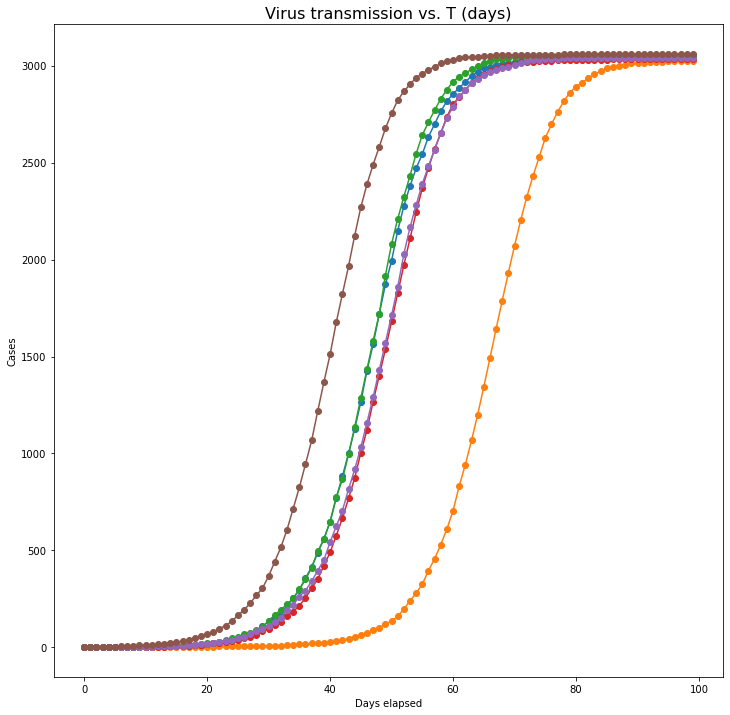

In [138]:
plot_ensemble(controls[1])

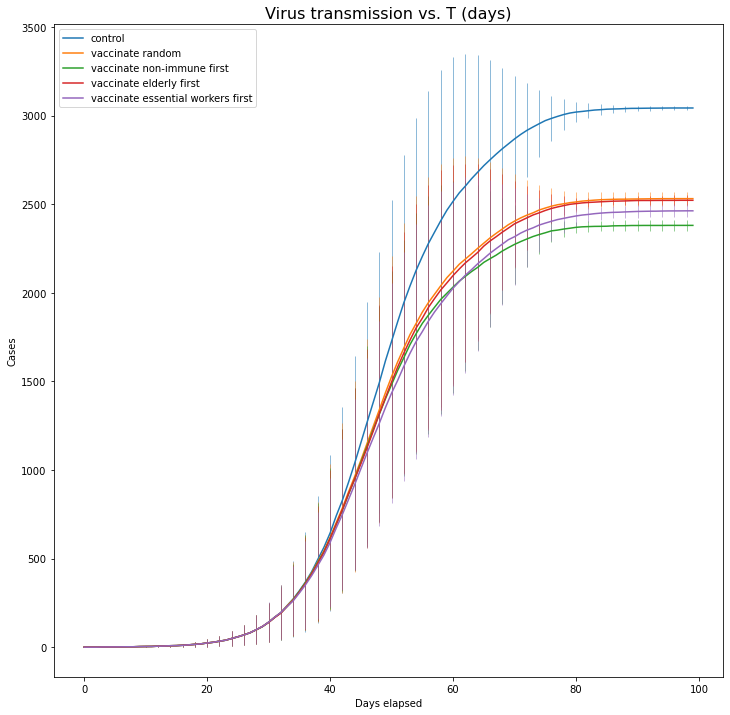

In [135]:
all_results = [r[1] for r in (controls, vaccine_random, vaccine_skip_survivors, vaccine_elderly_first, vaccine_essential_workers_first)]
all_labels = ['control', 'vaccinate random', 'vaccinate non-immune first', 'vaccinate elderly first', 'vaccinate essential workers first']
plot(all_results, range(100), all_labels)
# plot(results2)

## Limiting transmission

All vaccination campaigns did a good job of limiting transmission *when applied early enough*. Even applying at the beginning of exponential growth, the transmission still got to around 2/3 of the population due to the power of exponential growth and the linear growth of the number of vaccinations.

The random vaccinations and elderly-first rollouts limited transmission similarly - which makes sense because age and mortality was randomly applied, so both are really randomly applying vaccinations when decoupled from the mortality aspect. The essential worker and immune rollouts were moderately more effective, but not as much as one would expect. This may allude to the fact that most transmission occurs across households via core connections rather than strong connections that essential workers have with the rest of society.

In [ ]:
# plot(
#     [control, vaccinate_random_order, result_skip_survivor, result_elderly, result_essential],
#     ['Control', 'Vaccinate randomly', 'Selectively vaccinate those who have not caught the virus', 
#      'Vaccinate elderly first', 'Vaccinate essential workers first']
# )